# Tabular Cross-Entropy Method (CEM), 2 pts

In this notebook you will play with a simple reinforcement learning environment and learn a policy using Cross-Entropy method.

In [ ]:
# Install necessary libraries. If you encounter difficulties in local installation, use google colab.

!pip install swig
!pip install gymnasium[toy-text]

In this notebook we will use **Taxi** environment from Gymnasium library. First of all, read the [description](https://gymnasium.farama.org/environments/toy_text/taxi/) of this environment, try to understand the goal of the game, possible states and actions in the game and how the reward is calculated.

n_states = 500, n_actions = 6


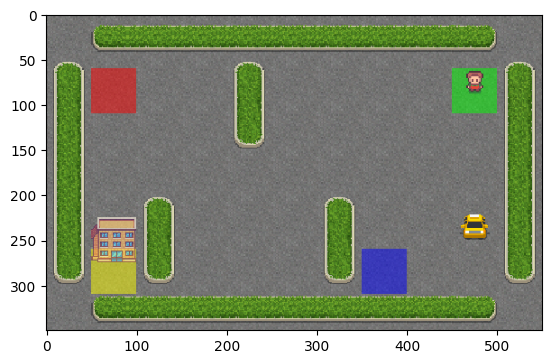

In [ ]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt

# Create environment
env = gym.make("Taxi-v3", render_mode="rgb_array")

n_states = env.observation_space.n
n_actions = env.action_space.n
print(f"n_states = {n_states}, n_actions = {n_actions}")

# Initialize environment
state, info = env.reset(seed=42)

# Show the current state
plt.imshow(env.render())


Let's play with the environment with random strategy and generate a video with results

In [ ]:
from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("Taxi-v3", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:

    s, info = env_monitor.reset()
    for t in range(100):
        a = env_monitor.action_space.sample()
        s, r, terminated, truncated, info = env_monitor.step(a)
        if terminated or truncated:
            break


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[0]

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)

# Create stochastic policy

Our policy is a probability distribution:

```policy[s,a] = P(take action a | in state s)```

Since we use integer state and action representations, you can use a 2-dimensional array to represent the policy.

Please initialize policy __uniformly__, that is, probabililities of all actions should be equal.


In [ ]:
policy = np.ones((n_states, n_actions)) / n_actions  # <your code here! Create an array to store action probabilities>

In [ ]:
# tests for uniform policy

assert type(policy) in (np.ndarray, np.matrix)
assert np.allclose(policy, 1./n_actions)
assert np.allclose(np.sum(policy, axis=1), 1)

# Play the game

In [ ]:
def generate_session(env, policy, t_max=10**4, test=False):
    """
    Play game until end or for t_max ticks.
    :param env: gymnasium environment
    :param policy: an array of shape [n_states,n_actions] with action probabilities
    :returns: list of states, list of actions and sum of rewards
    """
    states, actions = [], []
    total_reward = 0.

    s, info = env.reset()

    for t in range(t_max):

        # use the probabilities you predicted to pick an action
        if test:
            # on the test use the best (the most likely) actions at test
            # experiment
            # to account for eligible steps you may use info['action_mask']

            a = np.argmax(policy[s]) # < your code >

            # # ^-- hint: try np.argmax
        else:
            # sample proportionally to the probabilities,
            # don't just take the most likely action at train
            a = np.random.choice(a=policy.shape[1], p=policy[s]) #a = np.random.choice(n_actions, p=policy[s]) # < your code >
            # ^-- hint: try np.random.choice

        new_s, r, terminated, truncated, info = env.step(a)

        # record sessions
        states.append(s)
        actions.append(a)
        total_reward += r

        s = new_s
        if terminated or truncated:
            break

    return states, actions, total_reward

In [ ]:
# tests for generate_session

s, a, r = generate_session(env, policy)
assert type(s) == type(a) == list
assert len(s) == len(a)
assert type(r) == float

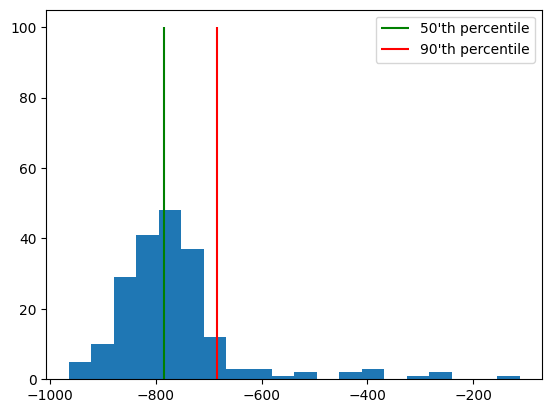

In [ ]:
# let's see the initial reward distribution
sample_rewards = [generate_session(env, policy, t_max=1000)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

### Cross-entropy method steps

In [ ]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    """
    Select states and actions from games that have rewards >= percentile
    :param states_batch: list of lists of states, states_batch[session_i][t]
    :param actions_batch: list of lists of actions, actions_batch[session_i][t]
    :param rewards_batch: list of rewards, rewards_batch[session_i]

    :returns: elite_states, elite_actions, both 1D lists of states and respective actions from elite sessions

    Please return elite states and actions in their original order
    [i.e. sorted by session number and timestep within session]
    """

    # <Compute minimum reward for elite sessions. Hint: use np.percentile >

    # reward_threshold = np.percentile(rewards_batch, percentile)
    # elite_states = []
    # elite_actions = []
    # for i in range(len(rewards_batch)):
    #     if rewards_batch[i] >= reward_threshold:
    #         elite_states.extend(states_batch[i])
    #         elite_actions.extend(actions_batch[i])
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states_batch = [states for i, states in enumerate(states_batch) if rewards_batch[i] >= reward_threshold]
    elite_actions_batch = [actions for i, actions in enumerate(actions_batch) if rewards_batch[i] >= reward_threshold]

    elite_states = [state for states in elite_states_batch for state in states]
    elite_actions = [action for actions in elite_actions_batch for action in actions]

    return elite_states, elite_actions

In [ ]:
# tests for select_elites

states_batch = [
    [1, 2, 3],     # game1
    [4, 2, 0, 2],  # game2
    [3, 1],        # game3
]

actions_batch = [
    [0, 2, 4],     # game1
    [3, 2, 0, 1],  # game2
    [3, 3],        # game3
]
rewards_batch = [
    3,  # game1
    4,  # game2
    5,  # game3
]

test_result_0 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=0)
test_result_30 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=30)
test_result_90 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=90)
test_result_100 = select_elites(
    states_batch, actions_batch, rewards_batch, percentile=100)

assert np.all(test_result_0[0] == [1, 2, 3, 4, 2, 0, 2, 3, 1])  \
    and np.all(test_result_0[1] == [0, 2, 4, 3, 2, 0, 1, 3, 3]),\
    "For percentile 0 you should return all states and actions in chronological order"
assert np.all(test_result_30[0] == [4, 2, 0, 2, 3, 1]) and \
    np.all(test_result_30[1] == [3, 2, 0, 1, 3, 3]),\
    "For percentile 30 you should only select states/actions from two first"
assert np.all(test_result_90[0] == [3, 1]) and \
    np.all(test_result_90[1] == [3, 3]),\
    "For percentile 90 you should only select states/actions from one game"
assert np.all(test_result_100[0] == [3, 1]) and\
    np.all(test_result_100[1] == [3, 3]),\
    "Please make sure you use >=, not >. Also double-check how you compute percentile."
print("Ok!")

Ok!


In [ ]:
def update_policy(elite_states, elite_actions):
    """
    Given old policy and a list of elite states/actions from select_elites,
    return new updated policy where each action probability is proportional to

    policy[s_i,a_i] ~ #[occurences of si and ai in elite states/actions]

    Don't forget to normalize policy to get valid probabilities and handle 0/0 case.
    In case you never visited a state, set probabilities for all actions to 1./n_actions

    :param elite_states: 1D list of states from elite sessions
    :param elite_actions: 1D list of actions from elite sessions

    """

    new_policy = np.zeros([n_states, n_actions])

    # <Your code here: update probabilities for actions given elite states & actions >
    # Don't forget to set 1/n_actions for all actions in unvisited states.

    for s, a in zip(elite_states, elite_actions):
        new_policy[s, a] += 1

    for i, row in enumerate(new_policy):
      row_sum = np.sum(row)
      new_policy[i] = np.full(n_actions, 1/n_actions) if row_sum == 0 else row/row_sum

    return new_policy

In [ ]:
# tests for update_policy

elite_states = [1, 2, 3, 4, 2, 0, 2, 3, 1]
elite_actions = [0, 2, 4, 3, 2, 0, 1, 3, 3]

new_policy = update_policy(elite_states, elite_actions)

assert np.isfinite(new_policy).all(
), "Your new policy contains NaNs or +-inf. Make sure you don't divide by zero."
assert np.all(
    new_policy >= 0), "Your new policy can't have negative action probabilities"
assert np.allclose(new_policy.sum(
    axis=-1), 1), "Your new policy should be a valid probability distribution over actions"
reference_answer = np.array([
    [1.,  0.,  0.,  0.,  0.],
    [0.5,  0.,  0.,  0.5,  0.],
    [0.,  0.33333333,  0.66666667,  0.,  0.],
    [0.,  0.,  0.,  0.5,  0.5]])
assert np.allclose(new_policy[:4, :5], reference_answer)
print("Ok!")

Ok!


# Training loop
Generate sessions, select N best and fit to those. Monitor the mean reward in iterations.

In [ ]:
# reset policy just in case
policy = np.ones([n_states, n_actions]) / n_actions

In [ ]:
n_sessions = 500  # sample this many sessions
percentile = 10  # take this percent of session with highest rewards
learning_rate = 0.5  # add this thing to all counts for stability

log = []

for i in range(100): # I changed it to 100 from 20 because at 20th iteration I've got only 50 mean reward change

    sessions = [generate_session(env, policy) for _ in range(n_sessions)] # < generate a list of n_sessions new sessions >
    states_batch, actions_batch, rewards_batch = zip(*sessions)

    # < compute mean reward for the current iteration and print >

    mean_reward = np.mean(rewards_batch)
    print(f"Iteration {i + 1}: Mean reward = {mean_reward}")
    log.append(mean_reward)

    elite_states, elite_actions = select_elites(
        states_batch, actions_batch, rewards_batch, percentile=percentile)

    new_policy = update_policy(elite_states, elite_actions)

    policy = (1 - learning_rate)*policy + learning_rate*new_policy


Iteration 1: Mean reward = -772.66
Iteration 2: Mean reward = -761.68
Iteration 3: Mean reward = -768.51
Iteration 4: Mean reward = -750.024
Iteration 5: Mean reward = -747.754
Iteration 6: Mean reward = -727.692
Iteration 7: Mean reward = -716.782
Iteration 8: Mean reward = -713.8
Iteration 9: Mean reward = -712.578
Iteration 10: Mean reward = -700.828
Iteration 11: Mean reward = -690.848
Iteration 12: Mean reward = -687.07
Iteration 13: Mean reward = -676.222
Iteration 14: Mean reward = -671.822
Iteration 15: Mean reward = -665.766
Iteration 16: Mean reward = -660.296
Iteration 17: Mean reward = -653.642
Iteration 18: Mean reward = -634.332
Iteration 19: Mean reward = -630.738
Iteration 20: Mean reward = -623.188
Iteration 21: Mean reward = -609.358
Iteration 22: Mean reward = -603.258
Iteration 23: Mean reward = -596.944
Iteration 24: Mean reward = -587.35
Iteration 25: Mean reward = -583.474
Iteration 26: Mean reward = -572.246
Iteration 27: Mean reward = -564.798
Iteration 28: Mea

Let's see the distribution of rewards for the found policy

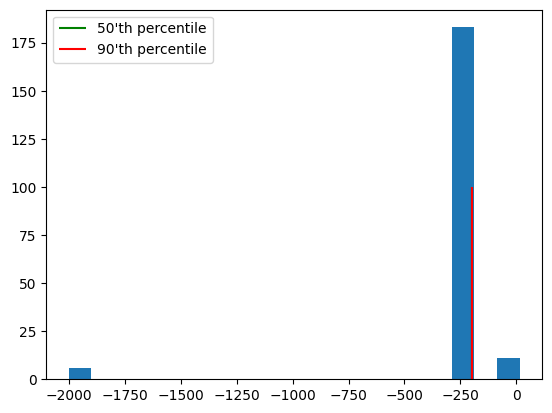

In [ ]:
sample_rewards = [generate_session(env, policy, t_max=1000, test=True)[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

Let's generate a video for our trained policy.

In [ ]:
# Record sessions

from gymnasium.wrappers import RecordVideo

with RecordVideo(
    env=gym.make("Taxi-v3", render_mode="rgb_array"),
    video_folder="./videos",
    episode_trigger=lambda episode_number: True,
) as env_monitor:
    sessions = [generate_session(env_monitor, policy) for _ in range(5)]


/usr/local/lib/python3.12/dist-packages/gymnasium/wrappers/rendering.py:296: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
import sys
from pathlib import Path
from base64 import b64encode
from IPython.display import HTML

video_paths = sorted([s for s in Path("videos").iterdir() if s.suffix == ".mp4"])
video_path = video_paths[0]  # You can also try other indices

if "google.colab" in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open("rb") as fp:
        mp4 = fp.read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML(
    """
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(
        data_url
    )
)


### Reflecting on results

You may have noticed that the taxi problem quickly converges from <-1000 to a near-optimal score and then descends back into -50/-100. This is in part because the environment has some innate randomness. Namely, the starting points of passenger/driver change from episode to episode.

In case CEM failed to learn how to win from one distinct starting point, it will simply discard it because no sessions from that starting point will make it into the "elites".

To mitigate that problem, you can either reduce the threshold for elite sessions (duct tape way) or  change the way you evaluate strategy (theoretically correct way). You can first sample an action for every possible state and then evaluate this choice of actions by running _several_ games and averaging rewards.